In [1]:
# Import dependencies
import pandas as pd
import sqlite3
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,precision_score
from sklearn.model_selection import train_test_split,GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import pickle
import warnings
from sklearn.pipeline import Pipeline
# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
# Connect to the SQLite database
conn = sqlite3.connect("../Resources/fetal_health_CTG_data.db")

# Query to select all data from the table
query = "SELECT * FROM fetal_health_CTG_data"

# Read data from the database into a DataFrame
fetal_df= pd.read_sql_query(query, conn)

# Close the connection
conn.close()



In [3]:
# Display the DataFrame
fetal_df.head()

,baseline_FHR_bpm,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolonged_decelerations,abnorm_ST_Var_Perc,mean_ST_Var,abnorm_LT_Var_Perc,...,FHR_hist_min,FHR_hist_max,FHR_hist_num_peaks,FHR_hist_num_zeroes,FHR_hist_mode,FHR_hist_mean,FHR_hist_median,FHR_hist_variance,FHR_hist_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1


In [4]:
#check the value counts of fetal health
health_status_ct=fetal_df["fetal_health"].value_counts()
health_status_ct

fetal_health
1    1655
2     295
3     176
Name: count, dtype: int64

In [5]:
# Separate the data into labels and features
# Separate the y variable, the labels
target=fetal_df["fetal_health"]

# Separate the X variable, the features
data = fetal_df.drop("fetal_health",axis=1)
features_df=data.columns

In [6]:
#check the label and features
print(target)
print(features_df)

0       2
1       1
2       1
3       1
4       1
       ..
2121    2
2122    2
2123    2
2124    2
2125    1
Name: fetal_health, Length: 2126, dtype: int64
Index(['baseline_FHR_bpm', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolonged_decelerations', 'abnorm_ST_Var_Perc', 'mean_ST_Var',
       'abnorm_LT_Var_Perc', 'mean_LT_Var', 'FHR_hist_width', 'FHR_hist_min',
       'FHR_hist_max', 'FHR_hist_num_peaks', 'FHR_hist_num_zeroes',
       'FHR_hist_mode', 'FHR_hist_mean', 'FHR_hist_median',
       'FHR_hist_variance', 'FHR_hist_tendency'],
      dtype='object')


In [7]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=48)

In [8]:
#value of count of training dataset
#X_train.shape
train_data=pd.Series(y_train).value_counts()
train_data

fetal_health
1    1245
2     220
3     129
Name: count, dtype: int64

In [9]:
#value of count of testing dataset
#x_test.shape()
test_data=pd.Series(y_test).value_counts()
test_data

fetal_health
1    410
2     75
3     47
Name: count, dtype: int64

In [10]:
#  Apply StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
#instantiate the random_oversampler 
Sampler = RandomOverSampler(random_state=48)
#X_sample, y_sample = Sampler.fit_resample(X_train,y_train)
X_sample, y_sample = Sampler.fit_resample(X_train_scaled,y_train)

# Fit the original training data to the random_oversampler 
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_sample, y_sample, random_state=48)

In [12]:
#value of count of testing dataset after ros
#x_test.shape()
test_data_ros=pd.Series(y_test_ros).value_counts()
test_data_ros

fetal_health
1    323
2    313
3    298
Name: count, dtype: int64

In [13]:
#value of count of training dataset after ros
#X_train.shape
train_data_ros=pd.Series(y_train_ros).value_counts()
train_data_ros=train_data_ros.sort_index()
train_data_ros

fetal_health
1    922
2    932
3    947
Name: count, dtype: int64

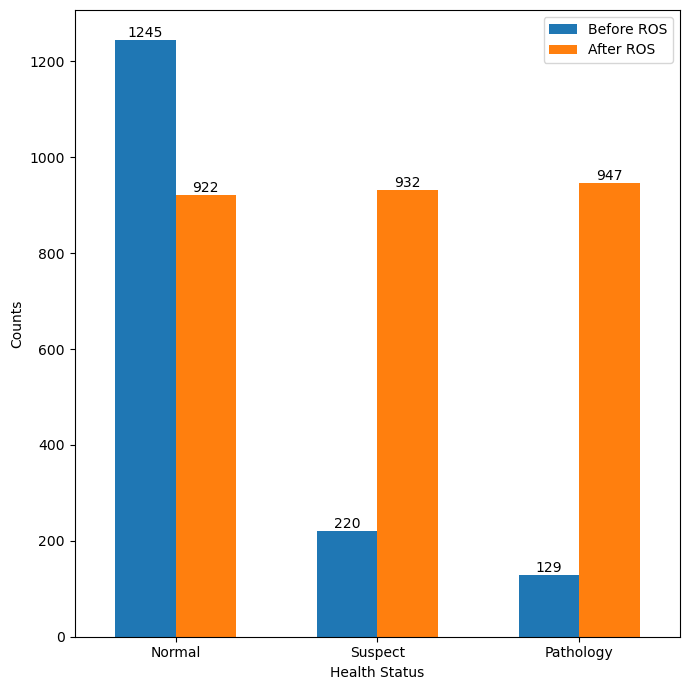

In [14]:
#set the labels
labels = ["Normal", "Suspect", "Pathology"]

# Generate evenly spaced x positions for the bars
x = np.arange(len(labels))

# Define the width of the bars
width = 0.30

   
fig, ax = plt.subplots(figsize=(7,7)) 


# Plot the bars for the original data
rects1 = ax.bar(x - width/2, train_data, width, label="Before ROS")

# Plot the bars for the oversampled data
rects2 = ax.bar(x + width/2, train_data_ros, width, label="After ROS")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel("Health Status")
ax.set_ylabel("Counts")
#ax.set_title("Training Data Before and After Random Oversampling")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add counts on top of each bar using enumerate
for i, rect in enumerate(rects1 + rects2):
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0,0.03),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')



# Set the x-axis limits to reduce the spacing between the categories
ax.set_xlim(-0.5, len(labels)-0.5)
# Display the plot
plt.tight_layout()
plt.savefig("../Images/RF_GBM")
plt.show()

In [15]:


# Define the best parameters
best_params = {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}

# Create the GBM model with the best parameters
gbm_model_final = GradientBoostingClassifier(**best_params, random_state=48)


In [16]:
# Fit the final GBM model to the training data
gbm_model_final.fit(X_train_ros, y_train_ros)

# Predict using the final GBM model
predictions_gbm_test = gbm_model_final.predict(X_test_ros)


In [17]:
# Predict train data using the final GBM model
predictions_gbm_train = gbm_model_final.predict(X_train_ros)
# Calculate accuracy score for training data
accuracy_train = accuracy_score(y_train_ros, predictions_gbm_train)
print("Training Accuracy:", accuracy_train)



Training Accuracy: 0.9996429846483399


In [18]:
# Calculate accuracy score for test data
accuracy_test = accuracy_score(y_test_ros, predictions_gbm_test)
print("Test Accuracy:", accuracy_test)

Test Accuracy: 0.9935760171306209


In [19]:
# Generate a confusion matrix
cm = confusion_matrix(y_test_ros, predictions_gbm_test)
print("Confusion Matrix:")
cm_df_gb=pd.DataFrame(cm,index=["Normal","Suspect","pathology"],columns=["Normal","Suspect","pathology"])
print("Gradient Boosting  Machine Classifier")

cm_df_gb

Confusion Matrix:
Gradient Boosting  Machine Classifier


,Normal,Suspect,pathology
Normal,317,6,0
Suspect,0,313,0
pathology,0,0,298


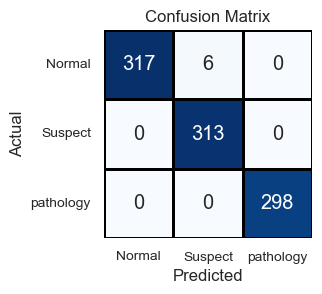

In [20]:
# Set font scale
sns.set(font_scale=1.2)

# Plot the confusion matrix
plt.figure(figsize=(2.7,2.7))
sns.heatmap(cm_df_gb, annot=True, fmt="d", cmap="Blues", cbar=False, square=True, linewidths=2, linecolor="black")
plt.xlabel("Predicted",fontsize=12)
plt.ylabel("Actual",fontsize=12)
plt.title("Confusion Matrix",fontsize=12)
plt.xticks(rotation=0,fontsize=10)
plt.yticks(rotation=0,fontsize=10)
# Adjusting layout to prevent cutting off labels
#plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.25)
plt.savefig("../Images/matrix",bbox_inches="tight")
plt.show()

In [21]:
# Generate a classification report
print("GB Classification Report :")
gb_report=classification_report(y_test_ros, predictions_gbm_test)
print(gb_report)

GB Classification Report :
              precision    recall  f1-score   support

           1       1.00      0.98      0.99       323
           2       0.98      1.00      0.99       313
           3       1.00      1.00      1.00       298

    accuracy                           0.99       934
   macro avg       0.99      0.99      0.99       934
weighted avg       0.99      0.99      0.99       934



In [22]:
#sklearn will automatically calculate feature importance
importances =gbm_model_final.feature_importances_

# We can sort the features by their importance
importances_sorted=sorted(zip(gbm_model_final.feature_importances_,data.columns), reverse=True)
print("Top 10 important features")
importances_sorted[:10]

Top 10 important features


[(0.276902387649442, 'abnorm_LT_Var_Perc'),
 (0.2572591064690467, 'abnorm_ST_Var_Perc'),
 (0.17812365241379596, 'FHR_hist_mean'),
 (0.07610426225717351, 'accelerations'),
 (0.03944690543263831, 'prolonged_decelerations'),
 (0.02854862786339007, 'FHR_hist_median'),
 (0.024209124014140226, 'FHR_hist_max'),
 (0.02163389393564462, 'FHR_hist_mode'),
 (0.019795772649130773, 'mean_ST_Var'),
 (0.01898059650602199, 'baseline_FHR_bpm')]

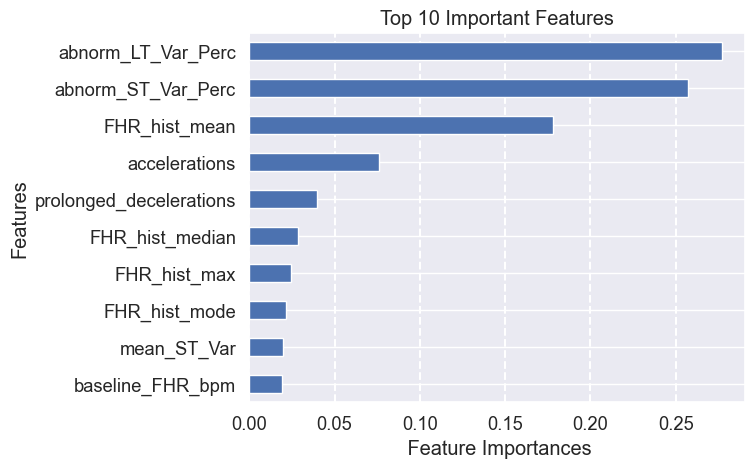

In [23]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(gbm_model_final.feature_importances_, data.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: "Feature Importances"}, inplace=True)
importances_sorted = importances_df.sort_values(by="Feature Importances")

# Selecting only the top 10 important features
top_10_importances = importances_sorted.tail(10)

# Plotting the top 10 important features
top_10_importances.plot(kind="barh",title="Top 10 Important Features", legend=False)
plt.xlabel(" Feature Importances")
plt.ylabel("Features")
# Adding grid lines
plt.grid(True, axis="x", linestyle="--", linewidth=1.5)
plt.savefig("../Images/GBM",bbox_inches="tight")
plt.show()

In [24]:
# Or for gradient boosting model
with open('gbm_model_final.pkl', 'wb') as file:
     pickle.dump(gbm_model_final, file)
